![solar irradiance](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/Solar_spectrum_en.svg/640px-Solar_spectrum_en.svg.png)
(Image: Nick84, [Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Solar_spectrum_en.svg).)

# Solar-weighted Gaussian Quadrature
— Notes by [Steven G. Johnson](https://math.mit.edu/~stevenj/), December 2019.

For many problems involving solar energy, e.g. simulating the efficiency of solar cells, it is necessary to compute integrals (also called *quadrature* in numerical contexts) over wavelength λ of the form:

$$
\int_a^b S(\lambda) f(\lambda) d\lambda
$$

for some desired wavelength interval $(a,b)$, where $f(\lambda)$ is application-specific and $S(\lambda)$ is a [solar irradiance](https://en.wikipedia.org/wiki/Solar_irradiance) spectrum: the **intensity of sunlight measured on Earth**.   For example, to [evaluate the efficiency of solar cells](https://www.osapublishing.org/oe/abstract.cfm?uri=oe-15-25-16986), typically $f(\lambda) = \lambda A(\lambda)$ where $A(\lambda)$ is the absorption spectrum of the photovoltaic device.

As is shown by the red curve above, S(λ) is an extremely complicated function [tabulated experimentally by the American Society for Testing and Materials (ASTM)](https://www.nrel.gov/grid/solar-resource/spectra-am1.5.html), displaying many sharp dips and oscillations due to atmosopheric absorption by different molecules.

### Problem: Lots of expensive function evaluations for accuracy

The challenge is that the application-specific f(λ) function is often **extremely expensive** to evaluate, e.g. for solar cells it involves solving Maxwell's equations (solving a partial differential equation) for each λ.   

Even if f(λ) is a smooth function, after multiplying by the solar weight S(λ) one obtains a very badly behaved integrand, requiring a **huge number of function evaluations** to obtain good accuracy.

### Solution: Specialized Gaussian quadrature scheme for S(λ)

We can solve this problem *very* efficiently because the **weight function** S(λ) is **fixed**, allowing us to **precompute** a quadrature scheme that takes the "nastiness" of S(λ) into account *analytically*, yielding a formula of the form:

$$
\int_a^b S(\lambda) f(\lambda) d\lambda \approx \sum_{i=1}^N w_i f(x_i)
$$

where the $N$ points $x_i$ are known as *quadrature points* and the coefficients $w_i$ are the corresponding *quadrature weights*.   The goal is to find these points and weights so that the integral is accurately approximated for smooth functions f(λ), where the effect of S(λ) is *precomputed* in $x_i$ and $w_i$.

A well-known method to accomplish this goal is [Gaussian quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature), in which clever theoretical methods are used to construct an $N$-point quadrature scheme that integrates *polynomial* functions $f(\lambda)$ *exactly* up to [degree](https://en.wikipedia.org/wiki/Degree_of_a_polynomial) $2N-1$.  Moreover, Gaussian quadrature [converges extremely quickly](https://doi.org/10.1137/060659831) with increasing $N$ for *smooth* functions f(λ).   All of this is true *regardless* of the smoothness (or lack thereof) of S(λ), since S(λ) is taken into account in the construction of the quadrature scheme.

#### Brief review of Gaussian quadrature

The construction of Gaussian quadrature schemes is reviewed extensively elsewhere. In brief, however, we first define an [inner product](https://en.wikipedia.org/wiki/Inner_product_space) $\langle p_1, p_2 \rangle = \int_a^b S(x) p_1(x) p_2(x) dx$ of real polynomials on $(a,b)$.  Then we perform a [Gram–Schmidt orthogonalization](https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process) of polynomials $\{1,x,x^2,\ldots\}$ to find [orthogonal polynomials](https://en.wikipedia.org/wiki/Orthogonal_polynomials) $\{q_0,q_1,\ldots\}$ with *respect to this weighted inner product*.   The Gaussian quadrature points $x_i$, amazingly, are the roots of $q_N(x)$.  Moreover, as is reviewed in e.g. chapter 37 of [Trefethen and Bau](http://people.maths.ox.ac.uk/~trefethen/text.html), these roots (and also the quadrature weights) can be obtained by solving a tridiagonal $N\times N$ eigenvalue problem whose entries are obtained by a [Lanczos algorithm](https://en.wikipedia.org/wiki/Lanczos_algorithm).  Essentially, we just need to integrate $2N$ polynomials against S(λ) — since these integrals only need to be done *once*, and are of cheap functions (polynomials), we can use expensive brute-force methods to perform them.   

All of this process, for an *arbitrary* weight function, is implemented for us in the Julia QuadGK.jl package. I should also mention one other wrinkle: for numerical stability when constructing Gaussian quadrature schemes computationally for arbitrary weight functions, QuadGK applies the Lanczos process to polynomials in the basis $\{T_0,T_1,T_2,\ldots\}$ of [Chebyshev polynomials](https://en.wikipedia.org/wiki/Chebyshev_polynomials), after rescaling the interval $(a,b)$ to $(-1,1)$, rather than using "textbook" basis $\{1,x,x^2,\ldots\}$. 

Below just need to supply QuadGK the solar-irradiance S(λ), and give it a bit of information on how to do the brute-force integrals on interpolated data by breaking it up into intervals.  Then it will construct our solar-weighted Gaussian quadrature scheme to any desired order $N$ and for any wavelength interval!

## Julia package requirements

The following Julia packages must be installed for this notebook to work: [QuadGK.jl](https://github.com/JuliaMath/QuadGK.jl) (numerical integration), [Dierckx.jl](https://github.com/kbarbary/Dierckx.jl) (cubic splines), [PyPlot.jl](https://github.com/JuliaPy/PyPlot.jl) (plots), and [ZipFile.jl](https://github.com/fhs/ZipFile.jl) (reading zip-compressed data).

Uncomment and execute the following line to install them.  (In IJulia, cells starting with `]` are commands sent to the [Julia package manager](https://docs.julialang.org/en/v1/stdlib/Pkg/).)

In [1]:
# ] add QuadGK Dierckx PyPlot ZipFile

## Solar irradiance data

To begin, let us download and import the [ASTM solar irradiance data](https://www.nrel.gov/grid/solar-resource/spectra-am1.5.html).  We will use the [ZipFile.jl](https://github.com/fhs/ZipFile.jl) package to unpack the `.zip` file containing the comma-delimited data, and then the `DelimitedFiles` standard-library package to read the data.

In [2]:
using ZipFile, DelimitedFiles

ASTM = let filename = download("https://www.nrel.gov/grid/solar-resource/assets/data/astmg173.zip")
    r = first(ZipFile.Reader(filename).files)
    data, header = readdlm(IOBuffer(read!(r, Array{UInt8}(undef, r.uncompressedsize))), ',', header=true, skipstart=1)
    data
end
λ, S = ASTM[:,1], ASTM[:,4]

([280.0, 280.5, 281.0, 281.5, 282.0, 282.5, 283.0, 283.5, 284.0, 284.5  …  3955.0, 3960.0, 3965.0, 3970.0, 3975.0, 3980.0, 3985.0, 3990.0, 3995.0, 4000.0], [2.5361e-26, 1.0917e-24, 6.1253e-24, 2.7479e-22, 2.8346e-21, 1.3271e-20, 6.7646e-20, 1.4614e-19, 4.9838e-18, 2.1624e-17  …  0.0077399, 0.0077679, 0.0078253, 0.0076997, 0.007528, 0.0074049, 0.0074503, 0.0073894, 0.0072263, 0.0071199])

The data consists of 2002 data points for wavelengths (λ) from 280nm to 4000nm:

In [3]:
@show extrema(λ)
@show length(λ);

extrema(λ) = (280.0, 4000.0)
length(λ) = 2002


Let's plot the data to see the "messy" irradiance spectrum:

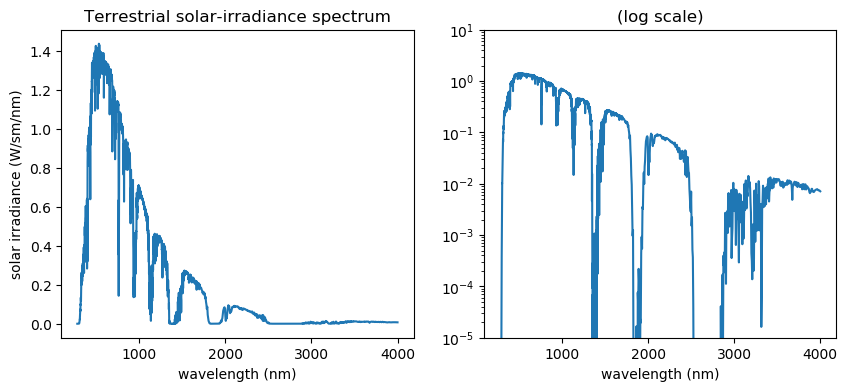

(1.0e-5, 10)

In [4]:
using PyPlot

figure(figsize=(10,4))

subplot(1,2,1)
plot(λ, S)
xlabel("wavelength (nm)")
ylabel("solar irradiance (W/sm/nm)")
title("Terrestrial solar-irradiance spectrum")

subplot(1,2,2)
semilogy(λ, S)
xlabel("wavelength (nm)")
title("(log scale)")
ylim(1e-5,10)

Since we are planning on integrating this data, it is nice to see how far out in the decaying "tail" we need to go.  To do this, let's compute the fraction of the integral:

$$
\mathrm{fraction}(\lambda) = \frac{\int_{280}^\lambda S(\lambda') d\lambda'}{\int_{280}^{4000} S(\lambda') d\lambda'}
$$

as a function of λ, superimposed on a normalized spectrum.

(For this plot, we will estimate the integral using a simple [Euler approximation](https://en.wikipedia.org/wiki/Euler_method).)

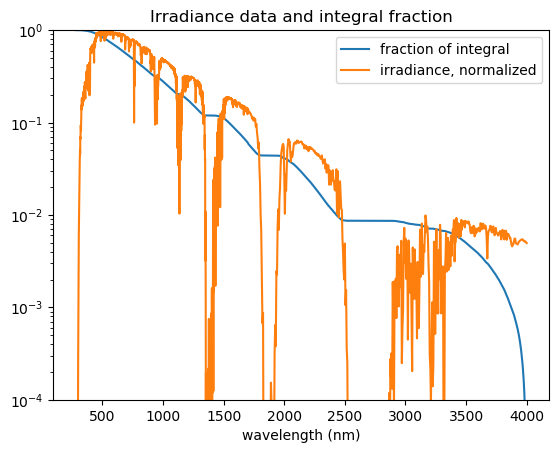

(0.0001, 1)

In [5]:
title("Irradiance data and integral fraction")
dλ = diff(λ)
semilogy(λ[1:end-1], 1 .- cumsum(S[1:end-1] .* dλ) / sum(S[1:end-1] .* dλ), "-")
semilogy(λ, S / maximum(S), "-")
xlabel("wavelength (nm)")
legend(["fraction of integral", "irradiance, normalized"])
ylim(1e-4, 1)

From the above plot, we can see that a significant fraction (≈ 1%) of the integral is in the "tail" from 3000–4000nm, so we need the whole spectrum if we want to compute integrals to many decimal places (unless the application's function f(λ) is rapidly decaying too). 

### Cubic-spline interpolation

To compute integrals, we need more than just a set of data points — we need to **interpolate** this tabulated data so that we can evaluate S(λ) for any λ in (200nm,4000nm).

Since the underlying physical spectrum is a smooth function, unless the data are extremely noisy it makes sense to use a [cubic spline](https://en.wikipedia.org/wiki/Spline_(mathematics)) interpolation, which interpolates the data by a sequence of cubic polynomials so that the first and second derivatives are also continuous.

However, there is a wrinkle — for Gaussian quadrature, we need to make sure that $S(\lambda) \ge 0$ everywhere (since $S$ must produce a weighted inner product on polynomials).   Our data points are all $> 0$, but it is conceivable that a spline interpolant will dip below zero at intermediate points.  To ensure that this is not the case, we will fit our cubic spline to $\sqrt{S}$ at the data points, and then square the result.

We will do this using the [Dierckx](https://github.com/kbarbary/Dierckx.jl) package in Julia, a wrapper around a popular Fortran library that supports irregularly-spaced data like the ASTM solar data.

In [6]:
using Dierckx
let Sinterp_sqrt = Spline1D(λ, sqrt.(S)) # spline for √S
    global Sinterp
    Sinterp(x) = Sinterp_sqrt(x)^2
end

Sinterp (generic function with 1 method)

The "knots" of a spline are the points where the interpolation switches from one polynomial to the next, i.e. points at which some higher derivative is discontinuous.  We will come back to this below, since knowing the points of discontinuity is crucial to computing our weight-function integrals quickly and accurately.

Let's plot the spline along with the underlying data in a smaller wavelength interval 400–500nm so that we can see the wiggles:

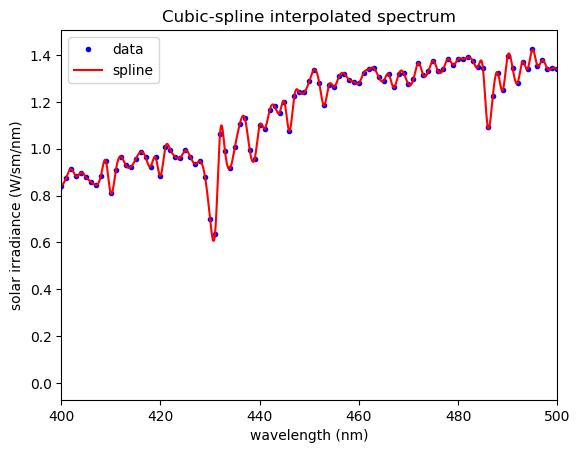

PyObject <matplotlib.legend.Legend object at 0x1426f0e80>

In [7]:
plot(λ, S, "b.")
xlabel("wavelength (nm)")
ylabel("solar irradiance (W/sm/nm)")
title("Cubic-spline interpolated spectrum")
xlim(400,500)

λinterp = range(400,500,length=1000)
plot(λinterp, Sinterp.(λinterp), "r-")

legend(["data", "spline"])

The spline fit looks reasonable — notice that the rapid oscillations encompass several data points in a row, so they are presumably real features of the data and not simply noise.

## Gaussian quadrature construction via QuadGK

The QuadGK package does almost all of the work for us in constructing a Gaussian quadrature rule for a given weight function, its `x, w = gauss(...)` functions that returns arrays of quadrature points `x` and weights `w`.

All we need to do is to give it the weight function, in this case our spline-interpolated data.   `gauss` will then laboriously compute a sequence of integrals of this weight function against polynomials.

Although we don't care *too* much about the speed of this process, since we only need to do it once for a given quadrature rule, it turns out that there is something simple we can do to speed it up.   Numerical integration is best for *smooth* functions, but our spline interpolant is *not* smooth: it has discontinuities (in some higher derivative) at the "knot" points (≈ data points).   To integrate such a *piecewise-smooth* function accurately, we should simply perform the integral piecewise.  The `gauss` function allows us to pass a `quad` argument with a custom integration routine, so below we pass a specialized `interpquad` routine that performs integrals by breaking them up into pieces at the knots.   (Remember: we are doing this work only during the *construction* of the quadrature rule for S(λ), not during the evaluation of the resulting integrals of f(λ).)

The result, below, is a `x, w = gaussquad_interpolant(N, X, W, a, b)` function that returns the `N`-point quadrature rule on the interval `(a, b)` for a weight function interpolated from data points `(X[j],W[j])`.

In [8]:
using QuadGK, Dierckx

function gaussquad_interpolant(N::Integer,
                               X::AbstractVector{<:Real}, W::AbstractVector{<:Real},
                               a::Real=minimum(X), b::Real=maximum(X);
                               rtol::Real=sqrt(eps(typeof(float(b-a)))),
                               interpdegree::Integer=3)
    # some quick argument sanity checks:
    all(w ≥ 0 for w in W) || throw(ArgumentError("weights must be nonnegative"))
    length(X) == length(W) || throw(DimensionMismatch("points and weights must have same length"))
    N > 1 || throw(ArgumentError("a positive order N is required"))
    a < b || throw(ArgumentError("endpoints b > a are required"))
    rtol > 0 || throw(ArgumentError("a positive rtol is required"))
    interpdegree > 0 || throw(ArgumentError("a positive interpdegree is required"))
    
    # construct a cubic-spline interpolation from the data.
    # … we fit √W and then square it below to ensure non-negativity.
    Winterp_sqrt = Spline1D(X, sqrt.(W), k=interpdegree)
    
    # break integration interval at knots
    xab = sort!(collect(Iterators.filter(x -> a < x < b, Dierckx.get_knots(Winterp_sqrt))))
    push!(pushfirst!(xab, a), b) # add endpoints
    
    # quadrature routine for W-weighted integrands, that breaks integrand up into each
    # interpolation interval at the knots.
    interpquad(f, _a, _b; kws...) = quadgk(f, xab...; kws...)
    
    return gauss(x -> Winterp_sqrt(x)^2, N, a, b; quad=interpquad, rtol=rtol)
end

gaussquad_interpolant (generic function with 3 methods)

## Solar quadrature rules

Now that we have the short function above, let's apply it to compute a 15-point Gaussian quadrature rule for the S(λ) weight function.  This will *exactly* integrate polynomial f(λ) up to degree 29, and should be good for any smooth functions as long as they aren't oscillating much faster than our 15 points can capture.

Here we calculate it, time how long the calculation takes with Julia's `@time` macro, and show the quadrature points and weights:

In [9]:
@time x15, w15 = gaussquad_interpolant(15, λ, S)

println()
@show x15
println()
@show w15;

 22.385776 seconds (46.21 M allocations: 2.137 GiB, 5.25% gc time)

x15 = [344.004412421539, 437.43127227603054, 568.1092994031569, 749.2781425390235, 981.3251032658463, 1247.7878424754654, 1617.303298586857, 2010.2545652003437, 2296.122189366414, 2721.7925560518984, 3154.6728694146204, 3476.4449824825892, 3700.612094656647, 3872.510794574371, 3975.787688337758]

w15 = [19.256241145558377, 116.43961249817175, 211.8590559664976, 215.79348793043496, 148.99914651430805, 85.16743526465572, 58.7953989544163, 18.385226469837132, 16.99406763245827, 0.7153456133066246, 1.530131473905365, 2.4515674336703217, 1.9590193110771037, 1.1100431577807464, 0.46101123801853444]


The calculation took about 22 seconds, which is not too bad since we only have to do this once.  But actually the calculation is faster than that — most of these 22 seconds are spent by Julia in [JIT compiling](https://en.wikipedia.org/wiki/Just-in-time_compilation) the computational routines.

Subsequently running the code, now that it has been compiled, is much quicker:

In [10]:
@time gaussquad_interpolant(15, λ, S);
@time gaussquad_interpolant(15, λ, S);
@time gaussquad_interpolant(15, λ, S);

  0.729540 seconds (8.57 M allocations: 154.116 MiB, 2.45% gc time)
  0.719003 seconds (8.57 M allocations: 154.116 MiB, 1.84% gc time)
  0.720868 seconds (8.57 M allocations: 154.116 MiB, 1.88% gc time)


We can also plot the points and weights.  Unsurprisingly, they vaguely resemble the solar spectrum itself, with more weight where the solar irradiance is greater:

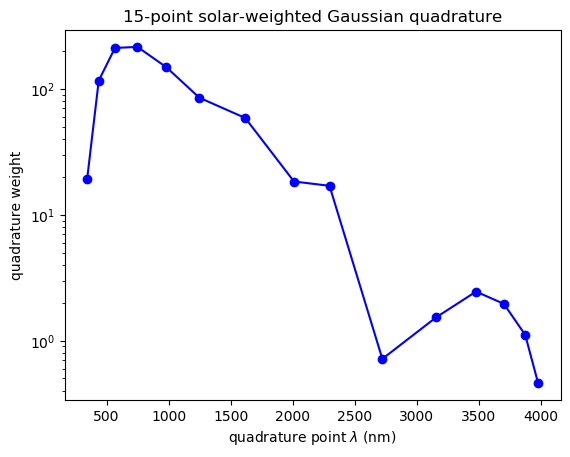

PyObject Text(0.5, 1, '15-point solar-weighted Gaussian quadrature')

In [11]:
semilogy(x15, w15, "bo-")
xlabel(L"quadrature point $\lambda$ (nm)")
ylabel("quadrature weight")
title("15-point solar-weighted Gaussian quadrature")

We'll also compute a **99-point** solar-weighted quadrature rule, suitable for integrating much more oscillatory functions.

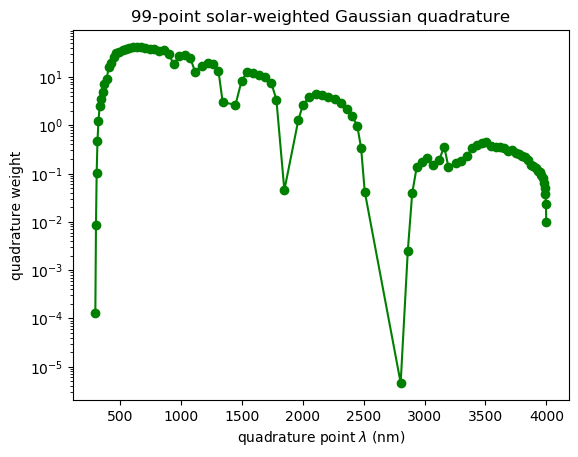

  6.041269 seconds (58.28 M allocations: 1.028 GiB, 1.66% gc time)

x99 = [296.58786520846525, 301.86932586906727, 307.3413862642167, 314.0101663463744, 322.2157186534005, 331.6588606552103, 343.16563211861506, 356.4718787589982, 371.43844861016, 388.4562139889681, 406.85926227327474, 426.0481717998874, 447.62901892787136, 469.92116394102163, 494.07400235193575, 519.8819737412621, 547.21371249863, 576.0744631926423, 606.46754270433, 638.2129109456624, 671.2959617860226, 705.7863072495503, 742.0507337674146, 780.5554341808609, 818.2455840936051, 858.0879046742818, 897.7411488242675, 940.8662643813793, 987.4902295689035, 1030.0610336012219, 1074.091374437584, 1117.2269901074096, 1173.443596282667, 1218.9715095166084, 1264.2332426026787, 1307.3216392819909, 1342.224915652247, 1447.3678952624173, 1497.1669408915898, 1542.2086303659403, 1591.7043105789685, 1642.3988363909662, 1692.8888886873513, 1741.451683376098, 1783.2390162887173, 1848.737471241858, 1963.9220689859833, 2001.8975232780376

In [12]:
@time x99, w99 = gaussquad_interpolant(99, λ, S)

println()
@show x99
println()
@show w99

semilogy(x99, w99, "go-")
xlabel(L"quadrature point $\lambda$ (nm)")
ylabel("quadrature weight")
title("99-point solar-weighted Gaussian quadrature");

Notice that it puts few quadrature points around wavelengths like 2500–3000nm where the solar irradiance is almost zero (due to strong absorption peaks). It still puts a lot of data points in the 3000–4000nm range where the irradiance is small but not tiny (≈ 1% of total), because integrating these ranges accurately is necessary if we want numeric integrals that are correct to many decimal places.

Computing the 99-point rule was more expensive, but still took less than 6 seconds.  If we need a 999-point rule (to integrate *extremely* oscillatory f(λ) functions), we could do that too without too much trouble.

## Validation and efficiency

To illustrate these quadrature rules and see how they compare to simpler methods, let's integrate the test function:
$$
    f(\lambda) = \sin(2\pi \lambda / 500)
$$
which oscillates with a period of 500nm (eight times in the ASTM data's 280–4000nm range).

(This is not too wiggly, but integrating it against S(λ) accurately is very challenging for simpler integration techniques.)

Let's plot it along with the solar spectrum:

In [13]:
f(x) = sin(2π*x/500) # test integrand

f (generic function with 1 method)

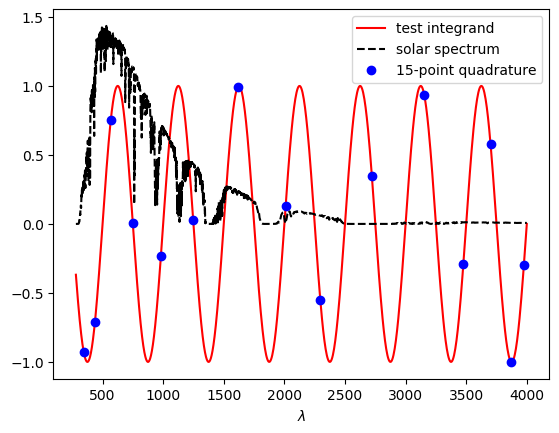

PyObject Text(0.5, 25.0, '$\\lambda$')

In [14]:
plot(λ, f.(λ), "r-")
plot(λ, Sinterp.(λ), "k--")
plot(x15, f.(x15), "bo")
legend(["test integrand", "solar spectrum", "15-point quadrature"])
xlabel(L"\lambda")

Above, the blue dots show the function f(x) sampled at the quadrature points $x_i$ of our 15-point solar-weighted Gaussian quadrature scheme.   This is **not very many points**!   Even without the S(λ) weight, extremely simple methods like the [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule) would not be able to integrate this f(x) accurately with so few points.  Capturing the S(λ) accurately as well would be crazy, except that the effect of S(λ) is already *exactly* taken into account by the solar-weighted quadrature scheme.

### Brute force

To begin with, we'll just compute the "exact" integral (to nearly [machine precision](https://en.wikipedia.org/wiki/Machine_epsilon)) by the brute-force Gauss–Kronrod quadrature function `quadgk` provided by the QuadGK package.

We won't be *completely* naive, however: instead of passing `280, 4000` as the integration limits, we'll pass `λ...`, which "splats" all of the data points: this causes `quadgk` to break the integral into 2001 sub-segments where our interpolant `Sinterp` is smooth, giving an extremely accurate result at the cost of lots of function evaluations.  We'll increment a global counter `cnt` in our integrand routine to keep track of the number of times `quadgk` evaluates our integrand.

The resulting integral `81.264730...` is accurate to nearly 15 significant digits, at the cost of 30,000 function evaluations.   That's fine for such a cheap `f(λ)`, but not if evaluating `f(λ)` required us to solve Maxwell's equations once for each λ!

In [15]:
cnt = 0
I,E = quadgk(x -> begin; global cnt += 1; Sinterp(x) * f(x); end, λ...)
println("got ∫S(λ)f(λ)dλ = $I ± $E after $cnt evaluations")

got ∫S(λ)f(λ)dλ = 81.29493915980758 ± 2.5898675124982475e-13 after 30015 evaluations


### Solar-weighted Gaussian quadrature

Next, we evaluate the same integral using our 15-point and 99-point solar-weighted Gaussian quadrature rules from above, and compare the results to the brute-force "exact" answer above.

Using **only 15 points**, we now obtain better than **1%** accuracy!  Using only 99 points, our result is accurate to **13 digits**.

Without knowing about the magic of Gaussian quadrature rules with precomputed weights, it might seem unimaginable that one could compute this crazy S(λ)f(λ) integral so accurately with so few points.

In [16]:
I15 = sum(f.(x15) .* w15)
println("got ∫S(λ)f(λ)dλ = $I15 ± $(abs(I15-I)) after 15 evaluations")

got ∫S(λ)f(λ)dλ = 81.86968138509843 ± 0.5747422252908478 after 15 evaluations


In [17]:
I99 = sum(f.(x99) .* w99)
println("got ∫S(λ)f(λ)dλ = $I99 ± $(abs(I99-I)) after 99 evaluations")

got ∫S(λ)f(λ)dλ = 81.29493915981057 ± 2.9842794901924208e-12 after 99 evaluations


### Brute force: Trapezoidal rule

If you are integrating against tabulated data like we have here, the first technique that might come to mind is the [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule).   If we have M data points for S(λ), we simply evaluate our integrand S(λ)f(λ) at **all M points** and interpolate with straight lines in between (adding up the area of trapezoids).

Here, that scheme is actually fairly accurate, to about 4 significant digits, but requires $M=2002$ function evaluations so it is horribly impractical for expensive integrands.

In [18]:
dλ = diff(λ)
fS = Sinterp.(λ) .* f.(λ)
Itrap = 0.5 * (sum(fS[1:end-1] .* dλ) + sum(fS[2:end] .* dλ))
println("got ∫S(λ)f(λ)dλ = $Itrap ± $(abs(I-Itrap)) after $(length(λ)) evaluations")

got ∫S(λ)f(λ)dλ = 81.27213873732622 ± 0.022800422481367377 after 2002 evaluations


### Brute force: Adaptive quadrature

Another naive approach might be to simply use an [adaptive quadrature](https://en.wikipedia.org/wiki/Adaptive_quadrature) method that evaluates the integrand at more and more points until a desired accuracy is achieved.   In fact, the `quadgk` routine provided by the QuadGK package is one such algorithm, based on a [Gauss–Kronrod method](https://en.wikipedia.org/wiki/Gauss%E2%80%93Kronrod_quadrature_formula).  

However, to resolve the extremely rapid oscillations of S(λ), especially since the **interpolated** data is **not smooth** (the third derivative is discontinuous), adaptive quadrature again takes a huge number of function evaluations.

Here, we see that it takes 5295 evaluations for 1% accuracy, and 12135 evaluations for 0.003% accuracy.  Again, this is not practical for expensive integrands.

In [19]:
cnt = 0
I′,E′ = quadgk(x -> begin; global cnt += 1; Sinterp(x) * f(x); end, minimum(λ), maximum(λ), rtol=1e-2)
println("got ∫S(λ)f(λ)dλ = $I′ ± $(abs(I-I′)) after $cnt evaluations")

got ∫S(λ)f(λ)dλ = 81.76990310756109 ± 0.47496394775350836 after 4755 evaluations


In [20]:
cnt = 0
I′,E′ = quadgk(x -> begin; global cnt += 1; Sinterp(x) * f(x); end, minimum(λ), maximum(λ), rtol=1e-3)
println("got ∫S(λ)f(λ)dλ = $I′ ± $(abs(I-I′)) after $cnt evaluations")

got ∫S(λ)f(λ)dλ = 81.29294492241281 ± 0.001994237394768561 after 11295 evaluations


### Convergence rate

As mentioned above, the accuracy of Gaussian quadrature typically improves *exponentially* ("spectral" convergence = faster than power-law) with the number $N$ of quadrature points if $f(\lambda)$ is a smooth function.   Let's see that here by plotting the error vs. $N$, both for the $f(\lambda)$ above and for a second function $f_2(\lambda)$ that oscillates $10\times$ more rapidly.

In [21]:
f₂(x) = sin(2π*x/50) # oscillates 10× faster than f(λ) from above

# brute-force integral, for refernce:
cnt = 0
I₂,E₂ = quadgk(x -> begin; global cnt += 1; Sinterp(x) * f₂(x); end, λ...)
println("got ∫S(λ)f₂(λ)dλ = $I₂ ± $E₂ after $cnt evaluations")

got ∫S(λ)f₂(λ)dλ = -2.4678641756502175 ± 8.250037931267041e-13 after 30015 evaluations


In [22]:
Ns = [5:2:33; 40:10:140]
err = Float64[]
err₂ = Float64[]
rule = Dict() # save quadrature rules in case we want them later
print("Working on N: ")
@time begin
    for N in Ns
        print(N, ", ")
        flush(stdout) # force immediate progress output
        x, w = gaussquad_interpolant(N, λ, S)
        push!(err, abs(sum(f.(x) .* w) - I) / abs(I))
        push!(err₂, abs(sum(f₂.(x) .* w) - I₂) / abs(I₂))
        rule[N] = (x,w)
    end
    println("\nDone.\n")
end

Working on N: 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 
Done.

 74.128992 seconds (743.95 M allocations: 13.040 GiB, 1.34% gc time)


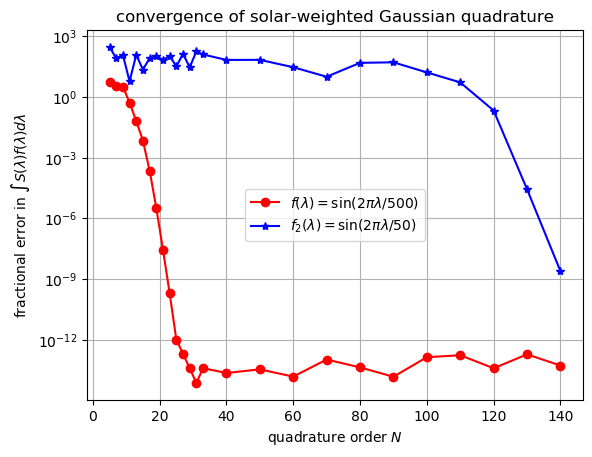

In [23]:
semilogy(Ns, err, "ro-")
semilogy(Ns, err₂, "b*-")
xlabel(L"quadrature order $N$")
ylabel(L"fractional error in $\int S(\lambda) f(\lambda) d\lambda$")
legend([L"f(\lambda) = \sin(2\pi\lambda/500)", L"f_2(\lambda) = \sin(2\pi\lambda/50)"])
title("convergence of solar-weighted Gaussian quadrature")
grid()

Notice that when the integrand $f(\lambda)$ is rapidly oscillating (or has other "sharp" features), you still need to sample it finely enough to capture the features of $f(\lambda)$. Only after you use a large enough $N$ \[to roughly fit $f(\lambda)$ to a polynomial of degree $N$\] does the spectral convergence "kick in."  (Still, we get 9 digits with just 140 points.)

For this $f_2$, even a 99-point quadrature rule is not enough: sampling $f_2(\lambda)$ at just 99 points clearly leads to [aliasing](https://en.wikipedia.org/wiki/Aliasing) effects in which the function appears to be oscillating at a much lower frequency:

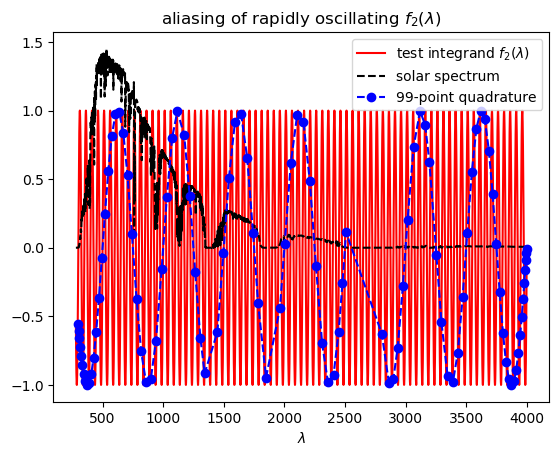

PyObject Text(0.5, 1, 'aliasing of rapidly oscillating $f_2(\\lambda)$')

In [24]:
λ₂ = range(minimum(λ), maximum(λ), length=10^4) # need a finer grid to plot f₂
plot(λ₂, f₂.(λ₂), "r-")
plot(λ₂, Sinterp.(λ₂), "k--")
plot(x99, f.(x99), "bo--")
legend([L"test integrand $f_2(\lambda)$", "solar spectrum", "99-point quadrature"])
xlabel(L"\lambda")
title(L"aliasing of rapidly oscillating $f_2(\lambda)$")

## Integrating from 280–1100nm

To [evaluate the efficiency of solar cells](https://www.osapublishing.org/oe/abstract.cfm?uri=oe-15-25-16986), typically $f(\lambda) = \lambda A(\lambda)$ where $A(\lambda)$ is the absorption spectrum of the photovoltaic device.   However, for silicon solar cells the absorption decays extremely (exponentially) rapidly for longer wavelengths, so there is not much point in integrating beyond 1100nm in many applications.

We might therefore want quadrature rules for **integrating from 280–1100nm**, and this is easy to do with our routines above.  Here are 15-point and 99-point quadrature schemes, for example:

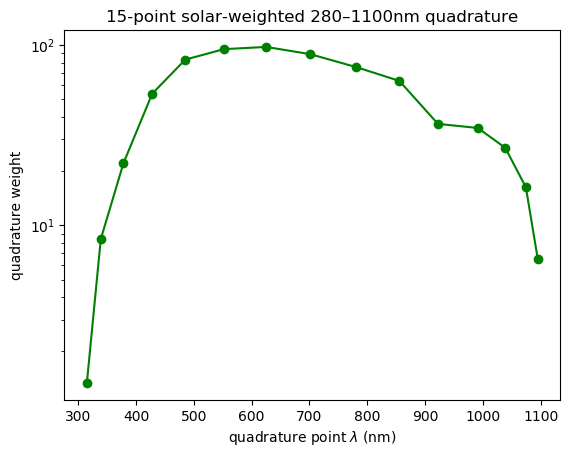

  6.196582 seconds (19.49 M allocations: 872.868 MiB, 6.29% gc time)

x15_280_1100 = [314.92138861379857, 338.98790910708885, 378.10600672294163, 427.94950407704505, 485.1905190444563, 552.1067339309991, 625.3396879244963, 701.5596398337402, 780.2841205412848, 855.4208991758636, 922.2792833260764, 991.2963062055389, 1038.767958061289, 1074.3681990593159, 1094.9461809391682]

w15_280_1100 = [1.333973017718305, 8.377298914715139, 22.07174596213444, 53.76755523744777, 83.10641623502435, 95.01468826523082, 97.74931402774925, 89.05527191929889, 75.63023902578047, 63.32419953505097, 36.54136558071805, 34.69678108345354, 26.89785055928815, 16.2570311658125, 6.500834387906066]


In [25]:
@time x15_280_1100, w15_280_1100 = gaussquad_interpolant(15, λ, S, 280, 1100)

println()
@show x15_280_1100
println()
@show w15_280_1100

semilogy(x15_280_1100, w15_280_1100, "go-")
xlabel(L"quadrature point $\lambda$ (nm)")
ylabel("quadrature weight")
title("15-point solar-weighted 280–1100nm quadrature");

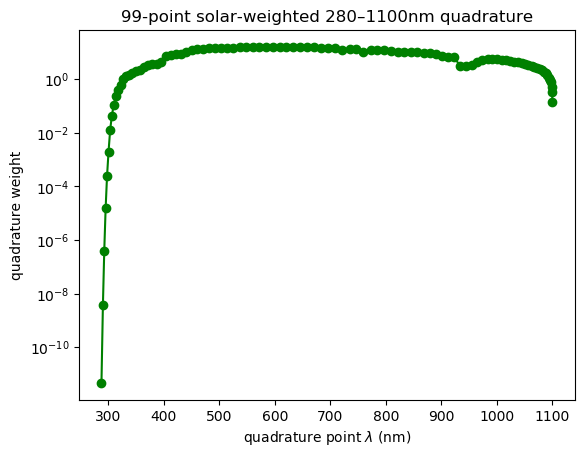

  1.927239 seconds (27.28 M allocations: 488.279 MiB, 2.02% gc time)

x99_280_1100 = [287.89611712096405, 290.4963794927568, 292.8934846413384, 295.39857234772063, 297.89685399630116, 300.61794400465965, 303.56476789393537, 306.6390274454292, 310.1026169782448, 313.7389365509126, 317.9102150484074, 322.3391261024797, 327.2194582804435, 332.2565374605655, 337.88152324239167, 343.723943702964, 350.13786088164625, 356.63505155055395, 363.9034361724103, 370.9251546208287, 378.66892150657543, 387.0039640670646, 395.38660587405695, 403.69454348570326, 412.4169757112663, 421.39102171161244, 430.80469360049557, 440.4477795140207, 450.2107566482326, 460.1875011612274, 470.45183723326033, 480.878795452604, 491.7457759129622, 502.6217307732638, 513.6700067535884, 525.1377563656818, 536.5855054663482, 548.2738993836978, 560.0475182623643, 572.0041205346463, 584.0506311521899, 596.3327165890763, 608.5787675144006, 620.9397102167209, 633.4755965857215, 645.8958363330935, 658.5503435939358, 671.07443

In [26]:
@time x99_280_1100, w99_280_1100 = gaussquad_interpolant(99, λ, S, 280, 1100)

println()
@show x99_280_1100
println()
@show w99_280_1100

semilogy(x99_280_1100, w99_280_1100, "go-")
xlabel(L"quadrature point $\lambda$ (nm)")
ylabel("quadrature weight")
title("99-point solar-weighted 280–1100nm quadrature");